In [ ]:
! pip install textstat transformers category_encoders

In [6]:
import os, random, textstat, spacy, re, string, itertools
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import category_encoders as ce

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
! gdown "1o_QH7OB56BBgPFFJLYMBzkbAwKeNj9XC"

Downloading...
From: https://drive.google.com/uc?id=1o_QH7OB56BBgPFFJLYMBzkbAwKeNj9XC
To: /content/text.csv
100% 9.29M/9.29M [00:00<00:00, 150MB/s]


In [4]:
'''Set dataset directory'''
ROOT_DIR = "/content"

# 1. Exploratory Data Analysis

## 1(a) Profile the dataset

In [5]:
df = pd.read_csv(os.path.join(ROOT_DIR, "text.csv"))

display(df.head())

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [8]:
print("df shape:", df.shape)

df shape: (3911, 8)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


## 1(b) Look at the target variable

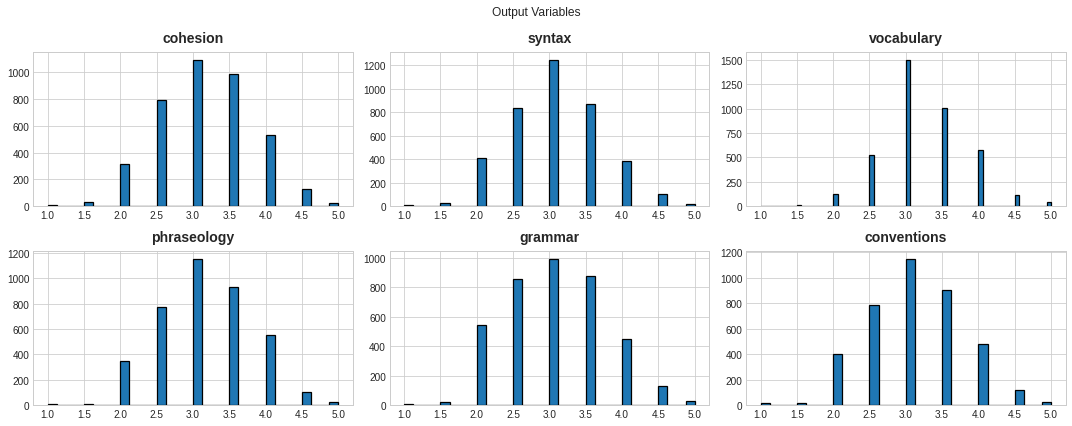

In [10]:
targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

fig, axes = plt.subplots(2, len(targets)//2, figsize=(15,6))

for i, target in enumerate(targets):
    ax = axes.flat[i]
    sns.histplot(x=target, data=df, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()

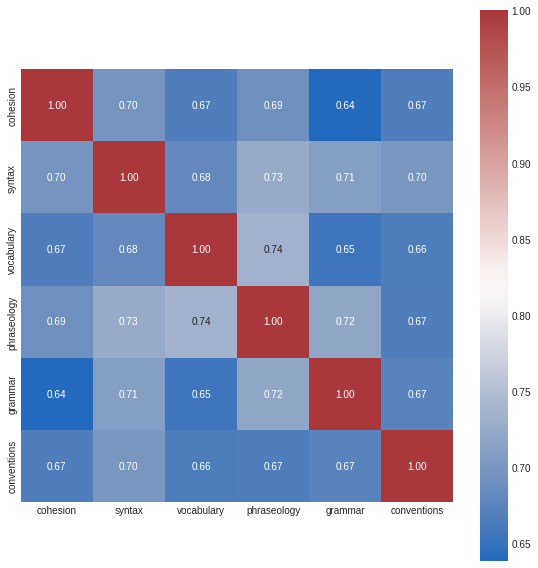

In [11]:
corr = df[targets].corr()
fig, ax = plt.subplots(figsize=(8,8))        
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, square=True, annot=True, cmap="vlag", fmt=".2f")
plt.show()

## 1(c) Text Analysis
- look at word and document statistics, especially as they relate to the target variables
- look at common words

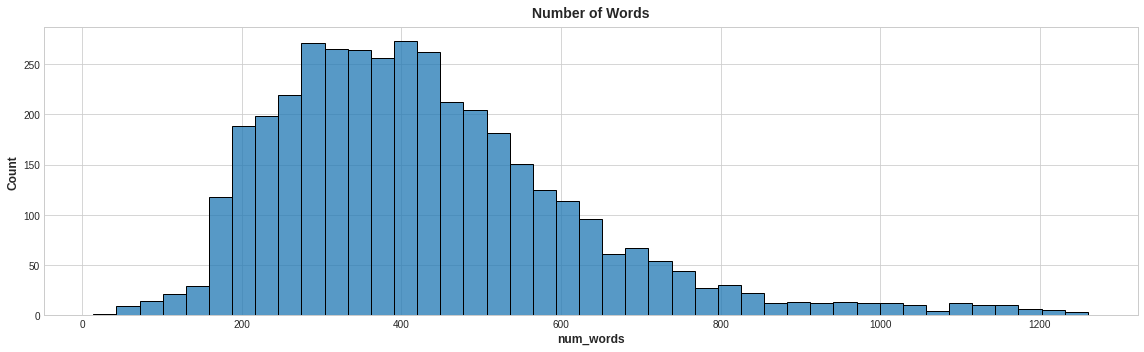

In [12]:
fig = plt.figure(figsize=(16, 5))
df['num_words'] = df['full_text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x="num_words")
plt.title("Number of Words")
plt.show()

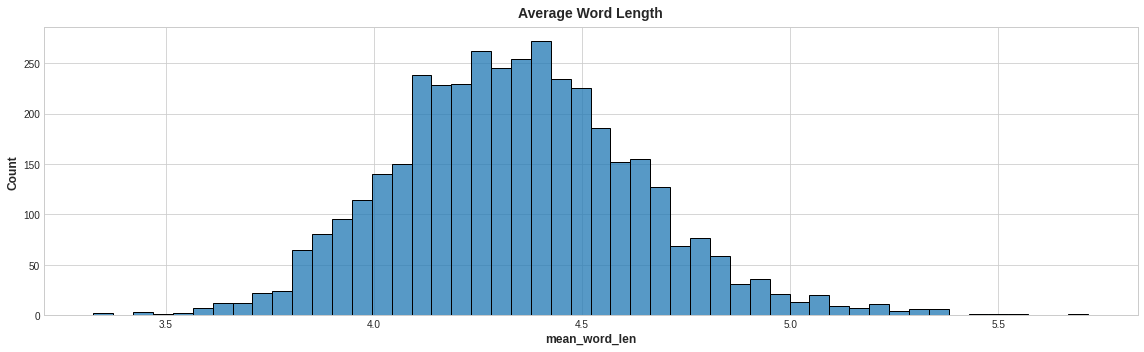

In [13]:
fig = plt.figure(figsize=(16, 5))
df['mean_word_len'] = df['full_text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))
sns.histplot(data=df, x="mean_word_len")
plt.title("Average Word Length")
plt.show()

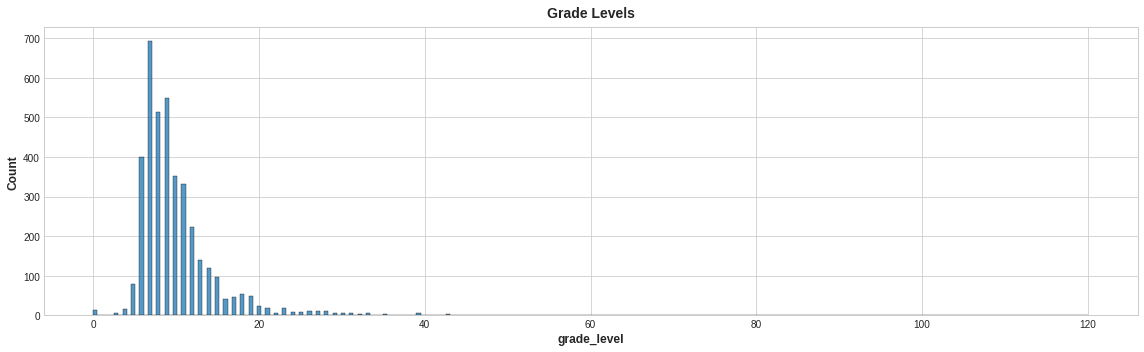

In [14]:
fig = plt.figure(figsize=(16, 5))
df['grade_level'] = df['full_text'].apply(lambda x: textstat.text_standard(x, float_output=True))
sns.histplot(data=df, x="grade_level")
plt.title("Grade Levels")
plt.show()

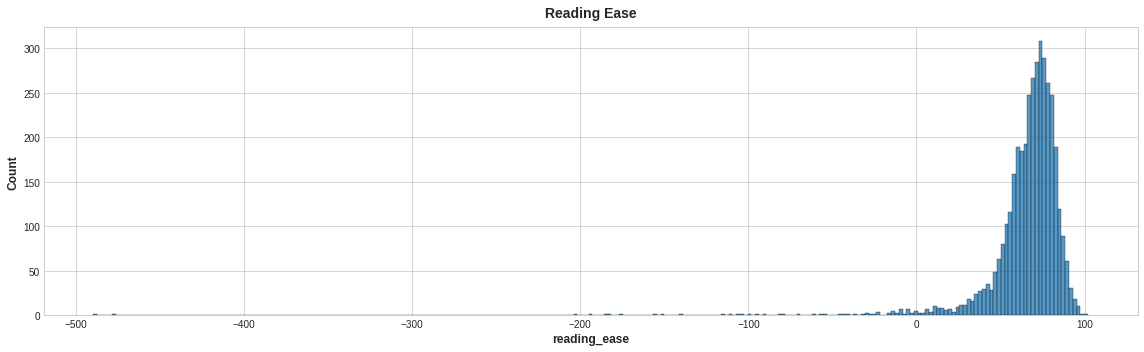

In [15]:
fig = plt.figure(figsize=(16, 5))
df['reading_ease'] = df['full_text'].apply(lambda x: textstat.flesch_reading_ease(x))
sns.histplot(data=df, x="reading_ease")
plt.title("Reading Ease")
plt.show()

In [16]:
'''Look at worst reading ease'''
print(df[df['reading_ease']==df['reading_ease'].min()]['full_text'].values[0])

Being yourself doesn't depends in how people see you, it depends on you because you are the only one that can choose to change or not, it makes no difference if you did something right or wrong the society always will discriminate and see that at the way they think it is,and you can't do anything about it, you are doing the things that you feel that are correct and how is the way how is has to be, however being in a world that is trying to make you something else is a great accomplishment because there is not way people make you change;

you had to live your life at the way you want it, you have the opportunity to express your feelings everywhere, and you are in the world to be happy and not to satisfy every single person

Sometimes it's hard for you to be deal in the society with opinions that hurt you and make you feel bad about it, and that is something that you cannot change, but it is something that help you to learn how to be more responsible when you are growing up and to be ove

In [17]:
'''Look at best reading ease'''
print(df[df['reading_ease']==df['reading_ease'].max()]['full_text'].values[0])

Would you like to have more time at school? I would like to have more time at school. Setting at class and learning more things. Getting work done and relaxing. I have three reason why we should have more time at school.

My first reason why we should have more time at5 school is getting work done. If theres more time at school,then theres more time to do your homework at school. Getting your homework done so you dont have to do ot at home because you finish your work at school. My reason is getting work done.

My second reason why we should have more time at school is your friends. School can get boring so thats why you have friends so you can hangout with them at school. Your friends can be your work buddy so you and your friends can work together at school so you can finish your work. You can have fun with your friends at school so it wont be so boring i school. My other reason is your friends.

My third reason why we should have more time at school is your grades. Is your grades ba

In [18]:
'''Look at highest grade level'''
print(df[df['grade_level']==df['grade_level'].max()]['full_text'].values[0])

my name is Generic_Name and my story is about cars

I bay a car and it new i live that car so mush so i stirt taking caer to it and befor I usto have a buskel and i usto love that baskel so mauh but i gat older so i stop riding a biskel and i stirt looking for a beges thengs whan i was a kid i usto so my dad driveng a car and i usto haveng fun in it

;and my drimm was to bay a car win i gro up and i stil looking for that drimm seccer is the only sport i like i use to play seccer win i weas 11 years old and i stil play that geame and i love it so mush but my lieg get hert so i stop playing it any moer and then i stirt fling better so i want to go bake to play my favert game seccer so i try ot for school and i stirt making frinds and play with them my favert game evry day i even like a gril becoes that game so l like that gril and i stirt playing wiht her and taking wihe her and i wanted her number so i stirt beang cloes to her so it bean a year so i finly say it i told her that i love h

In [19]:
'''Look at lowest grade level'''
print(df[df['grade_level']==df['grade_level'].min()]['full_text'].values[0])

The year book is for to not forget anything and it helps you lot will somtimes people don't like it but for me it helps me lot but we don't the have it any of thoes no more it lets you to not to foget to do your homework and what do have torrmorw and the next week But we have those any more because we are now 8th grades but the kids what year book to show thier family what spots they did even to show kids went to school even to show how there friends looks like and one day there family can met them even I agree to do it like what to show there family what did and there school looks like even for they can rember but also if there friends moves away and we will still rember even to love them so much but still I agree for to do the years book and I'am ok with it and what the year books still and I still love them and miss them lot I want them back and it actlly look good But like we only get them an a year it takes for ever to get and I think to pay to get your own one but I like and the 

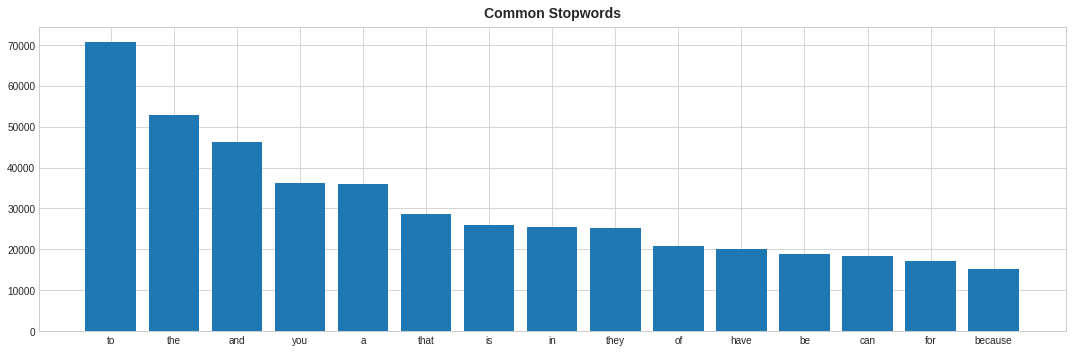

In [20]:
fig = plt.figure(figsize=(15, 5))

stop_words = set(stopwords.words('english'))
corpus = ''.join(df.full_text).split()

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
top_words = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:15] 
x, y = zip(*top_words)
plt.bar(x, y)
plt.title('Common Stopwords')
plt.show()

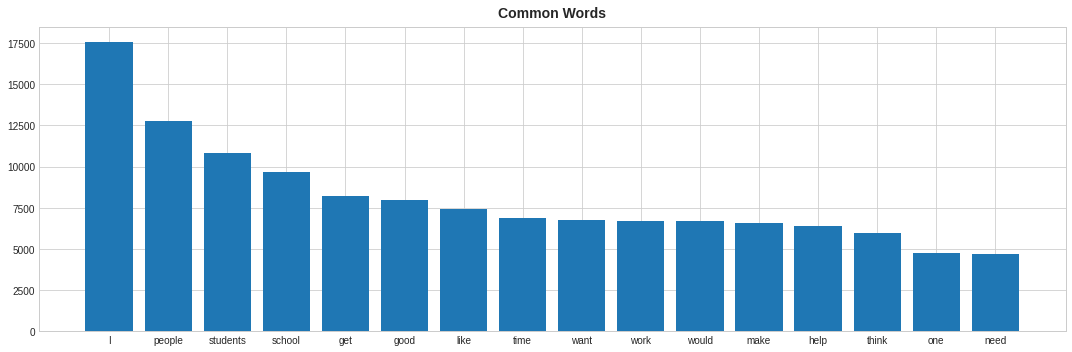

In [21]:
fig = plt.figure(figsize=(15, 5))

counter = Counter(corpus)
words = counter.most_common()

x, y = [], []
i = 0
for word, count in words:
    if (word not in stop_words):
        x.append(word)
        y.append(count)  
        i += 1
    if i > 15:
        break
plt.bar(x, y)
plt.title('Common Words')
plt.show()

In [22]:
special_characters = '''@#$%^*()-+_=<>'''
fig = plt.figure(figsize=(16, 5))
df['special_chars'] = df['full_text'].apply(lambda x: any(c in special_characters for c in x))
np.unique(df['special_chars'], return_counts=True)

(array([False,  True]), array([2804, 1107]))

<Figure size 1152x360 with 0 Axes>

In [23]:
print(df[df['special_chars']==True]['full_text'].values[0])

Dear Principal,

Our school should have a community center. The reasons why, are so students can learn what our community needs, how to make our community better place, and why is community important for students to know. Its a great to have a community center to know how we can make things better.

Students think community center takes their time away. but they have to learn what our community needs. students will participate in a group of students making a list what our community needs, therefore students will learn what our community needs! students will present their list of things our community needs! due to that students will be giving extra credit for the ones who have low grades!

Some students don't participate because their friends say its waste of time. it would not be waste of time when you get to know how our community can be a better place for us. students should know that the program is about our own lives, because if our community is bad well our lives are going to be b

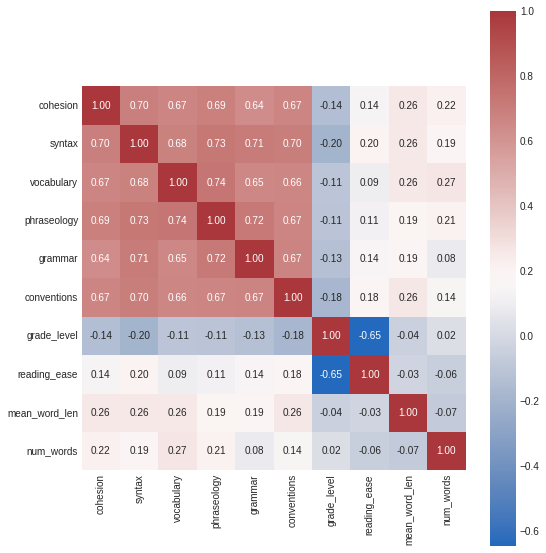

In [24]:
corr = df[targets+['grade_level', 'reading_ease', 'mean_word_len', 'num_words']].corr()
fig, ax = plt.subplots(figsize=(8,8))        
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, square=True, annot=True, cmap="vlag", fmt=".2f")
plt.show()

## 1(d) Look at possible labelings of the text

In [25]:
zsc = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [31]:
candidate_labels = ["remote learning", "homework", "hobbies", "jobs", "vacation", "teachers", "bullying"]

In [32]:
sample_df = df.sample(n=50)
results = zsc(sample_df["full_text"].tolist(), candidate_labels, batch_size=22)

In [33]:
zsc_labels = []
for result in results:
  label = result['labels'][np.argmax(result['scores'])]
  zsc_labels.append(label)

In [34]:
sample_df["zsc_label"] = zsc_labels

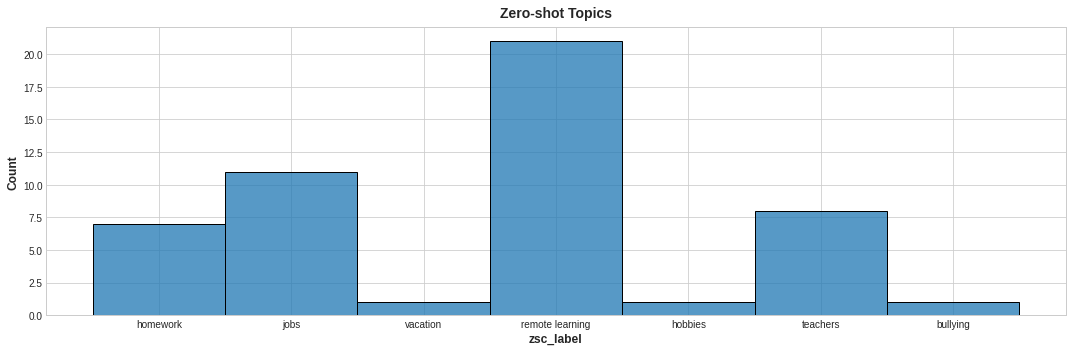

In [35]:
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=sample_df, x="zsc_label")
plt.title("Zero-shot Topics")
plt.show()

## 1(e) Look at any anomolous texts

In [55]:
anom_df = df[(df["grade_level"] > 20)]

In [56]:
anom_df.shape

(169, 13)

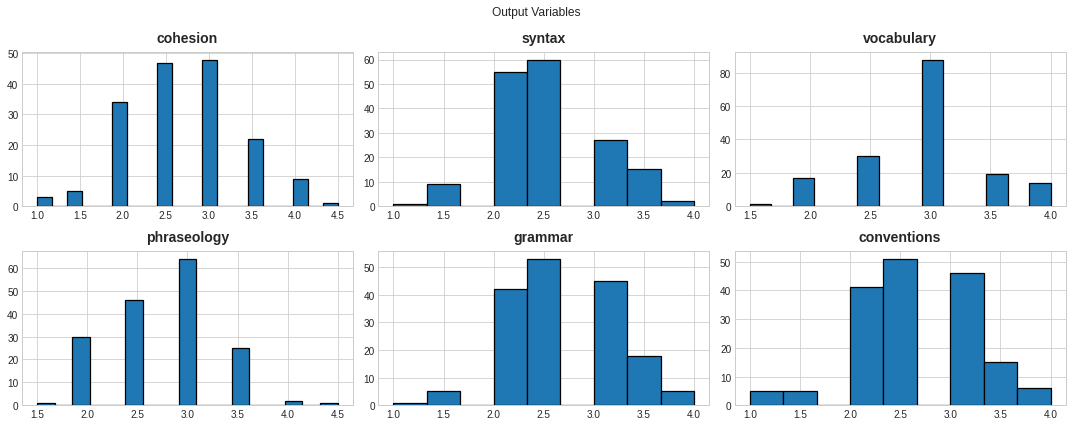

In [57]:
targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

fig, axes = plt.subplots(2, len(targets)//2, figsize=(15,6))

for i, target in enumerate(targets):
    ax = axes.flat[i]
    sns.histplot(x=target, data=anom_df, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()

# 2. Import and Preprocess Data

In [ ]:
def preprocess_data(df,  cat_features=None):
    
    # Specify categorical variables
    if cat_features is not None:
        for name in cat_features:
            df[name] = df[name].astype("category")
            # Add a None category for missing values
            if "None" not in df[name].cat.categories:
                df[name].cat.add_categories("None", inplace=True)
                

    # create test data set
    train, test = train_test_split(df, test_size=0.2)


    return train, test

In [ ]:
df = pd.read_csv(os.path.join(ROOT_DIR, "text.csv"), index_col="text_id")
train, test = preprocess_data(df, cat_features=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [ ]:
'''encode the target variable'''
enc = ce.one_hot.OneHotEncoder()
y_train = enc.fit_transform(train[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']])
y_test = enc.transform(test[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']])

In [ ]:
train = train.join(y_train)
test = test.join(y_test)

# 3. Set up Configuration

In [ ]:
config = {
    'model': 'distilbert-base-uncased',
    'num_classes' :54,
    'dropout': 0.,
    'batch_size': 6,
    'epochs': 2,
    'lr': 2e-5,
    'weight_decay': 0.01,
    'warmup_steps' : 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'tokenizer' :{
        'max_length': 512,
        'truncation':True
    }
}

# 4. Create Datasets and Dataloaders
- set the classes for the dataset module
- define the tokenizer

In [ ]:
class TextDataset:
    def __init__(self, df, config, classes=None, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = classes
        self.max_len = config['tokenizer']['max_length']
        self.truncation = config['tokenizer']['truncation']
        self.tokenizer = tokenizer
        self.is_test = is_test
        
    def __getitem__(self,idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                          None,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          truncation=self.truncation,
                                          padding='max_length'
                                         )
        inputs = {
            "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
            #"token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx,self.classes].to_list()
        
        '''NEED to check this for correct output'''
        inputs["labels"] = torch.tensor(label, dtype=torch.long)
        
        return inputs
    
    def __len__(self):
        return len(self.df)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

In [ ]:
train_ds = TextDataset(train, config, classes= y_train.columns, tokenizer=tokenizer)
test_ds = TextDataset(test, config, tokenizer=tokenizer, is_test=True)

# 5. Define the Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(config["model"], num_labels=config["num_classes"])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_

# 6. Model Training

https://huggingface.co/transformers/v3.2.0/custom_datasets.html
https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=I4R39UTxNKTk

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            #token_type_ids=inputs['token_type_ids']
        )
        loss = nn.BCEWithLogitsLoss()(outputs['logits'],
                                          inputs['labels'].float())
        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',         
    num_train_epochs=config['epochs'],              
    per_device_train_batch_size=config['batch_size'],  
    per_device_eval_batch_size=config['batch_size'],   
    warmup_steps=config['warmup_steps'],               
    weight_decay=config['weight_decay'],              
)

trainer = CustomTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_ds,         
    eval_dataset=test_ds           
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3128
  Num Epochs = 2
  Instantaneous batch size per device = 6
  Total train batch size (w. parallel, distributed & accumulation) = 6
  Gradient Accumulation steps = 1
  Total optimization steps = 1044
  Number of trainable parameters = 66994998


Step,Training Loss
500,0.331200
1000,0.257700


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1044, training_loss=0.29242026760203627, metrics={'train_runtime': 326.2927, 'train_samples_per_second': 19.173, 'train_steps_per_second': 3.2, 'total_flos': 829484552650752.0, 'train_loss': 0.29242026760203627, 'epoch': 2.0})

In [ ]:
trainer.save_model("trained_text_model")

Saving model checkpoint to trained_text_model
Configuration saved in trained_text_model/config.json
Model weights saved in trained_text_model/pytorch_model.bin


# 7. Check Predictions

In [ ]:
# loading the model you previously trained
model = AutoModelForSequenceClassification.from_pretrained("./trained_text_model")

# arguments for Trainer
test_args = TrainingArguments(
    output_dir = ".",
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = config["batch_size"],   
    dataloader_drop_last = False    
)

# init trainer
trainer = Trainer(
              model = model, 
              args = test_args
              )

test_results = trainer.predict(test_ds)

loading configuration file ./trained_text_model/config.json
Model config DistilBertConfig {
  "_name_or_path": "./trained_text_model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LA

In [ ]:
mapping = {0:1.0, 1:1.5, 2:2.0, 3:2.5, 4:3.0, 5:3.5, 6:4.0, 7:4.5, 8:5.0,}

preds = [[mapping[pos] for pos in np.argmax(i.reshape(6,9), axis=1)] for i in test_results[0]]

In [ ]:
labels = test[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].values

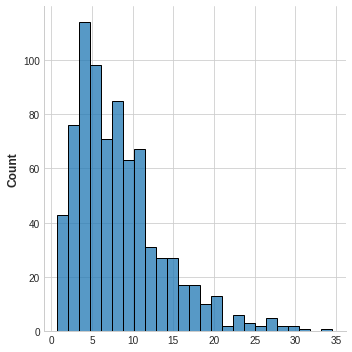

In [ ]:
sns.displot(np.sum((preds-labels)**2, axis=1))

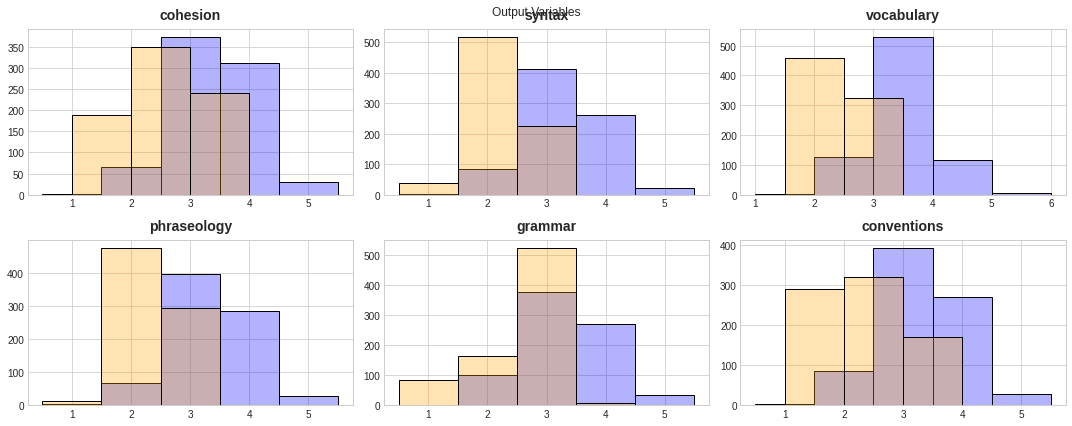

In [ ]:
targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
preds_df = pd.DataFrame(preds, columns = targets).astype("category")

fig, axes = plt.subplots(2, len(targets)//2, figsize=(15,6))

for i, target in enumerate(targets):
    ax = axes.flat[i]
    sns.histplot(x=target, data=test, alpha=0.3, ax=ax, color="blue")
    sns.histplot(x=target, data=preds_df, alpha=0.3, ax=ax, color="orange")
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()